In [23]:
import matlab.engine
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import datetime
from scipy.io import loadmat
from collections import defaultdict
from IPython.display import clear_output
import math
import warnings
warnings.filterwarnings('ignore')

eng = matlab.engine.start_matlab()

In [24]:
quietDays = np.array(eng.quiet())
# Quiet days from 2009/09/5 to 2009/09/19
# quietDays[1580-1] = 2009/09/14

year = np.int16(quietDays[381-1][0])
month = np.int16(quietDays[381-1][1])
day = np.int16(quietDays[381-1][2])
# year = 2012
# month = 9
# day = 6

numberOfDaysWithData = 3


startDateMatlab = [year, month, day, 0, 0, 0]
endDateMatlab = [year, month, day+numberOfDaysWithData, 23, 59, 59]

startDate = datetime.datetime(year, month, day, 0, 0, 0)
endDate = datetime.datetime(year, month, day+numberOfDaysWithData, 23, 59, 59)


stationsWithNoData = []
stationsNonexistentInFolder = []
stationsOut = dict()
dotsX=[]
dotsY=[]
dotsHeights=[]
stationIndicatorVariation = defaultdict(list)

mat = loadmat("../../../../opt/dir.indices/station.mat")

allMatData = mat.get("station", "none")[0]
allStationCodes=np.array([])
allStationLatgeos=np.array([])

for x in allMatData:
    allStationCodes=np.append(allStationCodes,x[1][0])
    allStationLatgeos=np.append(allStationLatgeos,x[3][0])
    
latMin=20
latMax=60
    

In [25]:
stationIndicatorRatioVariation = defaultdict(list)
numberOfMinutesNeededInTheTimeStamp=0
timeBetweenValues=0
numberOfValues=0
dataResolution=0
latMin=40
latMax=60
indicatorVariationArray = np.array([])
localIndicatorVariationArray = np.array([])
indicatorVariationArrayLocalTime = np.array([])
localNormalized01StationIndicatorVariation = np.array([])
stationsPerLat = defaultdict(list)
normalizedStationIndicatorVariation = defaultdict(list)
normalized01StationIndicatorVariation = defaultdict(list)
maxValueinDataset=0
minValueinDataset=0
latsWithoutData = np.array([])
ReconstructedArray = np.array([])

In [24]:
def GenerateTrainingSet():
    global year
    global month
    global day
    global startDate
    global endDate
    global startDateMatlab
    global endDateMatlab
    global stationsWithNoData
    global stationsNonexistentInFolder
    global stationsOut
    global dotsX
    global dotsY
    global dotsHeights
    global indicatorVariationArrayLocalTime
    
    stationsWithNoData = []
    stationsNonexistentInFolder = []
    stationsOut = dict()
    dotsX=[]
    dotsY=[]
    dotsHeights=[]
    stationIndicatorVariation = defaultdict(list)
    index=0
    for i in range(1500, 1520, numberOfDaysWithData-2):
        year = np.int16(quietDays[i][0])
        month = np.int16(quietDays[i][1])
        day = np.int16(quietDays[i][2])
        
        print "Requesting Matlab     ",
        RequestMatlab()
        print "Done"
        print"Create the arrays, normalize data and resize     ",
        MakeStationIndicatorVariation()
        ManuallyNormalizeData01()      
        makeIndicatorVariationArray(False,True)
        ResizeForPlot()   
        print "Done"
        print "Reconstruct latitudes without data at {} degrees     ".format(latsWithoutData),
        ReconstructedArray = PredictIndicatorForAllLatitudes(indicatorVariationArrayLocalTime)
        print "Done"
        np.save("../TrainingDataset/x_train/indicatorVariationArrayLocalTime{}".format(index), ReconstructedArray)
        print "Remove data in the second training vector     ",
        ArrayWithGaps=RemoveData(ReconstructedArray)
        print "Done"
        np.save("../TrainingDataset/x_train_lines/indicatorVariationArrayLocalTime{}".format(index), ArrayWithGaps)
        index+=1
        print("Matrix saved for date: {}".format(startDate))
        clear_output(wait=True)
    
GenerateTrainingSet()       

Requesting Matlab      Done
Create the arrays, normalize data and resize     

KeyboardInterrupt: 

In [26]:
def RemoveData(array):
    fromLat=46
    toLat=50
    target=np.full((toLat-fromLat, array.shape[1]), np.nan)
    c=0
    for i in range(fromLat,toLat):
        target[c]=array[i-latMin]
        array[i-latMin]=np.full(array.shape[1],np.nan)
        c+=1
    return array

In [27]:
def RequestMatlab():
    global startDateMatlab, endDateMatlab, startDate, endDate, year, month, day
    for i in range(0,allStationCodes.shape[0]): 
        if allStationLatgeos[i]>latMin and allStationLatgeos[i]<latMax:
            try:
                startDate = datetime.datetime(year, month, day, 0, 0, 0)
                endDate = startDate+datetime.timedelta(days=numberOfDaysWithData)

                startDateMatlab = [startDate.year, startDate.month, startDate.day, 0, 0, 0]
                endDateMatlab = [endDate.year, endDate.month, endDate.day, 0, 0, 0]

                stationsOut[allStationCodes[i]] = eng.indices_alpha(matlab.double(startDateMatlab), matlab.double(endDateMatlab),str(allStationCodes[i]))
            except:
                stationsNonexistentInFolder.append(st)

In [28]:
def IndicatorCalculation(dataSt, timeshift, currentDate, igrf):
    
#     a1=np.float32(dataSt.get("a1")[timeshift])
#     x=np.float32(dataSt.get("x")[timeshift])
    x1=np.float32(dataSt.get("x1")[timeshift])
    x2=np.float32(dataSt.get("x2")[timeshift])
#     x3=np.float32(dataSt.get("x3")[timeshift])
#     x4=np.float32(dataSt.get("x4")[timeshift])
#     y=np.float32(dataSt.get("y")[timeshift])
    y1=np.float32(dataSt.get("y1")[timeshift])
#     y2=np.float32(dataSt.get("y2")[timeshift])
#     y3=np.float32(dataSt.get("y3")[timeshift])
#     y4=np.float32(dataSt.get("y4")[timeshift])
#     z=np.float32(dataSt.get("z")[timeshift])
    z1=np.float32(dataSt.get("z1")[timeshift])
#     z2=np.float32(dataSt.get("z2")[timeshift])

    ratio = ((math.sqrt(pow(x1, 2)+pow(y1, 2)+pow(z1, 2)))/igrf)
#     weight = gaussian(ratio, 1, 0)
    return np.round(x2,10), ratio

In [29]:
def CalculateIGRF(dataSt, currentDate):    
    stLongeo=np.float32(dataSt.get("longeo"))
    stLatgeo=np.float32(dataSt.get("latgeo"))
    stAlt=np.float32(dataSt.get("alt"))
    
    currentDateMatlab = [currentDate.year, currentDate.month, currentDate.day, currentDate.hour, currentDate.minute, currentDate.second]
    b=eng.igrf(matlab.double([stLongeo]), matlab.double([stLatgeo]), matlab.double([stAlt]), matlab.double([currentDateMatlab]), nargout=4)
    return b[3]

In [30]:
def MakeStationIndicatorVariation():
    
    global stationIndicatorVariation
    global stationIndicatorRatioVariation
    global stationIndicatorVariation
    global numberOfMinutesNeededInTheTimeStamp
    global timeBetweenValues
    global numberOfValues
    global dataResolution
    global latMin
    global latMax
    
    stationIndicatorRatioVariation = defaultdict(list)
    stationIndicatorVariation.clear()
    numberOfMinutesNeededInTheTimeStamp = 1440*numberOfDaysWithData
    timeBetweenValues = 10
    numberOfValues = numberOfMinutesNeededInTheTimeStamp/timeBetweenValues
    dataResolution = 0

    if float(360%(numberOfMinutesNeededInTheTimeStamp/timeBetweenValues)).is_integer():
        dataResolution = 360/(numberOfMinutesNeededInTheTimeStamp/timeBetweenValues)

        for st in stationsOut.keys():
            if stationsOut[st]:
                if stationsOut[st].get("latgeo") > latMin and stationsOut[st].get("latgeo") < latMax:
                    igrf=CalculateIGRF(stationsOut[st], startDate)
                    delta = endDate-startDate
                    totalMinutes = (delta.total_seconds()+1)/60
                    for i in range(0, np.int16(totalMinutes), timeBetweenValues):
                        try:
                            update = datetime.timedelta(minutes=i)
                            currentDate = startDate+update
                            magneticValue, ratio = IndicatorCalculation(stationsOut.get(st), i, currentDate, igrf)
                            stationIndicatorVariation[st].append(magneticValue)
                            stationIndicatorRatioVariation[st].append(ratio)
                        except:
                            None

    else:
        print("!ERROR! -- Your timeBetweenValues must be a multiple of the chosen time delta's amount of minutes -- !ERROR!")
        sys.exit

In [31]:
def normalizeWithGivenBounds(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]               

def ManuallyNormalizeData01():
    global normalizedStationIndicatorVariation
    global normalized01StationIndicatorVariation
    global maxValueinDataset
    global minValueinDataset
    normalizedStationIndicatorVariation = defaultdict(list)
    normalized01StationIndicatorVariation = defaultdict(list)
    maxValueinDataset=0
    minValueinDataset=0
    max_values = np.array([])
    min_values = np.array([])
    max_values_ratio = np.array([])
    min_values_ratio = np.array([])
    
    for st in stationsOut.keys():
        if stationIndicatorVariation[st]:
            if not math.isnan(stationIndicatorVariation[st][0]):
                max_values = np.append(max_values, max(stationIndicatorVariation[st])) 
                min_values = np.append(min_values, min(stationIndicatorVariation[st]))
                max_values_ratio = np.append(max_values_ratio, max(stationIndicatorRatioVariation[st])) 
                min_values_ratio = np.append(min_values_ratio, min(stationIndicatorRatioVariation[st])) 

    totalMax = max(max_values)
    totalMin = min(min_values)
    totalMaxRatio = max(max_values_ratio)
    totalMinRatio = min(min_values_ratio)
    maxValueinDataset = totalMax
    minValueinDataset = totalMin
    
    bounds = np.array([0,1])   
    boundsRatio = np.array([-1,1])   
    for st in stationsOut.keys():
        if stationIndicatorVariation[st]:
            localMax = max(stationIndicatorVariation[st])
            localMin = min(stationIndicatorVariation[st])
            localMaxRatio = max(stationIndicatorRatioVariation[st])
            localMinRatio = min(stationIndicatorRatioVariation[st])
            
            IndicatorVariationAppliedRatio=stationIndicatorVariation.copy()
#             for i in range(0, len(stationIndicatorVariation[st])):
#                 IndicatorVariationAppliedRatio[st][i] = stationIndicatorVariation[st][i]*stationIndicatorRatioVariation[st][i]
            normalized01StationIndicatorVariation[st] = normalizeWithGivenBounds(np.array(IndicatorVariationAppliedRatio[st]), {'actual': {'lower': totalMin, 'upper': totalMax}, 'desired': {'lower': bounds[0], 'upper': bounds[1]}})

In [32]:
def indexValueOnLocalTime(array, st, i):
    numberOfValuesLong = array.shape[1]
    localTimeValuesArray = np.full((180, numberOfValuesLong), np.nan)
    long = float(stationsOut[st].get("longeo"))
    shiftValues = np.round((long*4)/timeBetweenValues,0)
    initialShiftValues = shiftValues
    decreasingIndex=0
    increasingIndex=0
    for y in range(numberOfValues/numberOfDaysWithData,numberOfValues):
        if y+shiftValues>=array.shape[1]:
            localTimeValuesArray[i][np.int16(y-(y-shiftValues))-decreasingIndex] = array[i][numberOfValues/numberOfDaysWithData-decreasingIndex]
            decreasingIndex+=1
        else:
            localTimeValuesArray[i][np.int16(y-y+shiftValues+increasingIndex)] = array[i][y]
            increasingIndex+=1
            
    return localTimeValuesArray[i] 

In [33]:

def makeIndicatorVariationArray(normalizedGauss, normalizedScaler):
    global indicatorVariationArray
    global localIndicatorVariationArray
    global indicatorVariationArrayLocalTime
    global localNormalized01StationIndicatorVariation
    global stationsPerLat
    
    indicatorVariationArray = np.full((180, len(normalized01StationIndicatorVariation[normalized01StationIndicatorVariation.keys()[1]])), np.nan)
    localIndicatorVariationArray = np.full_like(indicatorVariationArray, np.nan)
    indicatorVariationArrayLocalTime = np.full((180, len(normalized01StationIndicatorVariation[normalized01StationIndicatorVariation.keys()[1]])), np.nan)
    localNormalized01StationIndicatorVariation = np.full((180, len(normalized01StationIndicatorVariation[normalized01StationIndicatorVariation.keys()[1]])), np.nan)
    stationsPerLat = defaultdict(list)

    intermediateLocalIndicatorVariationArray = np.empty_like(localIndicatorVariationArray)
    intermediateLocalNormalized01StationIndicatorVariation = np.empty_like(localNormalized01StationIndicatorVariation)
    alreadyFilled = False
    for st in stationsOut.keys():
        alreadyFilled=False
        for i in range(latMin, latMax):
            if not isinstance(stationsOut[st], matlab.mlarray.double):
                if i == np.round(np.int16(stationsOut[st].get("latgeo")),0):
                    if stationsOut[st].get('longeo')<40:
                        stationsPerLat[i+90].append(st)
                        if len(stationsPerLat[i+90])>1:
                            alreadyFilled=True
                        if normalizedScaler:
                            if normalized01StationIndicatorVariation[st]:
                                if alreadyFilled==True:
                                    stName = stationsPerLat[i+90][stationsPerLat[i+90].index(min(stationsPerLat[i+90]))-1]
                                    localIndicatorVariationArray[i+90] = normalized01StationIndicatorVariation[stName]
                                    localNormalized01StationIndicatorVariation[i+90] = normalized01StationIndicatorVariation[stName]
                                    indicatorVariationArrayLocalTime[i+90] = indexValueOnLocalTime(localNormalized01StationIndicatorVariation, stName, i+90)
                                    indicatorVariationArray[i+90] = localIndicatorVariationArray[i+90]
                                else:
                                    localIndicatorVariationArray[i+90] = normalized01StationIndicatorVariation[st]
                                    localNormalized01StationIndicatorVariation[i+90] = normalized01StationIndicatorVariation[st]
                                    indicatorVariationArrayLocalTime[i+90] = indexValueOnLocalTime(localNormalized01StationIndicatorVariation, st, i+90)
                                    indicatorVariationArray[i+90] = localIndicatorVariationArray[i+90]

                            else: 
                                if len(stationIndicatorVariation[st])!=0:
                                    indicatorVariationArray[i+90]=stationIndicatorVariation[st]
                                    indicatorVariationArrayLocalTime[i+90] = indexValueOnLocalTime(indicatorVariationArray, st, i+90)
                                else:
                                    None
                else:
                    None

In [34]:
def ResizeForPlot():
    global indicatorVariationArrayLocalTime
    global indicatorVariationArray
    indicatorVariationArrayResized = np.empty([latMax-latMin, numberOfValues-((numberOfValues/numberOfDaysWithData)*2)])
    indicatorVariationArrayLocalTimeResized = np.empty([latMax-latMin, numberOfValues-((numberOfValues/numberOfDaysWithData)*2)])
    m=0
    for i in range(latMin+90, latMax+90):
        a=0
        for y in range(numberOfValues/numberOfDaysWithData,numberOfValues-(numberOfValues/numberOfDaysWithData)):
            indicatorVariationArrayResized[m][a]=indicatorVariationArray[i][y]
            a+=1
        m+=1
    indicatorVariationArray = np.empty_like(indicatorVariationArrayResized)
    indicatorVariationArray=indicatorVariationArrayResized[:]

    m=0
    for i in range(latMin+90, latMax+90):
        a=0
        for y in range(numberOfValues/numberOfDaysWithData,numberOfValues-(numberOfValues/numberOfDaysWithData)):
            indicatorVariationArrayLocalTimeResized[m][a]=indicatorVariationArrayLocalTime[i][y]
            a+=1
        m+=1
    indicatorVariationArrayLocalTime = np.empty_like(indicatorVariationArrayLocalTimeResized)
    indicatorVariationArrayLocalTime=indicatorVariationArrayLocalTimeResized[:]

In [35]:
def PredictIndicatorForAllLatitudes(baseArray):
    global ReconstructedArray, latsWithoutData
    latsWithoutData = np.array([])
    predictionArray = np.empty_like(baseArray)
    predictionArray=np.copy(baseArray)
    modelTuned = ParametersTuningPoly(predictionArray,baseArray.shape[1]/2)
    for i in range(0,baseArray.shape[0]):
        specificLatitudeTimePrediction = np.full(baseArray.shape[1], np.nan)
        if math.isnan(np.sum(baseArray[i])):
            latsWithoutData = np.append(latsWithoutData, i+latMin)
            for y in range(0,baseArray.shape[1]):
                if (math.isnan(baseArray[i][y])):
                    specificLatitudeTimePrediction[y] = GetIndicatorLongPrediction(i,y,modelTuned,predictionArray)
            predictionArray[i] = specificLatitudeTimePrediction
    return predictionArray

In [36]:
def GetIndicatorLongPrediction(latitude,longitude, params, baseArray):
    indicatorLatVariation = np.array([])
    for i in range(0, baseArray.shape[0]):
        indicatorLatVariation = np.append(indicatorLatVariation, baseArray[i][longitude])
    y = np.array(indicatorLatVariation)
    x = np.arange(0, baseArray.shape[0], 1)
    x,y = RemoveInfNan(x, y)
    return PolyRegression(x,y,params).predict(latitude)

In [37]:
def RemoveInfNan(latValues, indicatorValues):
    indexDeleteY = np.array([])
    for i in range(0, indicatorValues.shape[0]):
        if math.isinf(indicatorValues[i]) or math.isnan(indicatorValues[i]):
            indexDeleteY = np.append(indexDeleteY, i)
    newY = np.delete(indicatorValues, indexDeleteY)
    newX = np.delete(latValues, indexDeleteY)
    newY=newY.reshape(newY.shape[0],1)
    newX=newX.reshape(newY.shape[0],1)
    
    return newX, newY

In [38]:
from sklearn.svm import SVR

def SupportVectorRegression(latValues, indicatorValues,params):
    svr_rbf = SVR(kernel='rbf', C=params['C'], gamma=params['gamma'])
    model = svr_rbf.fit(latValues, indicatorValues)
    
    return model

def PolyRegression(latValues, indicatorValues, params):
    poly_grid = PolynomialRegression()
    poly_grid.set_params(**params)
    poly_grid.fit(latValues, indicatorValues)
    return poly_grid

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

def ParametersTuningPoly(baseArray,long):
    indicatorLatVariation = np.array([])
    for i in range(0, baseArray.shape[0]):
        indicatorLatVariation = np.append(indicatorLatVariation, baseArray[i][long])

    y = np.array(indicatorLatVariation)
    x = np.arange(0, baseArray.shape[0], 1)

    x, y = RemoveInfNan(x, y)
    
    paramsTuning = {'polynomialfeatures__degree': np.arange(2,5,1), 'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]}
    poly_gridTuning = GridSearchCV(PolynomialRegression(), paramsTuning, cv=10, scoring='r2', verbose=0)
    poly_gridTuning.fit(x, y)
    return poly_gridTuning.best_params_

In [40]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

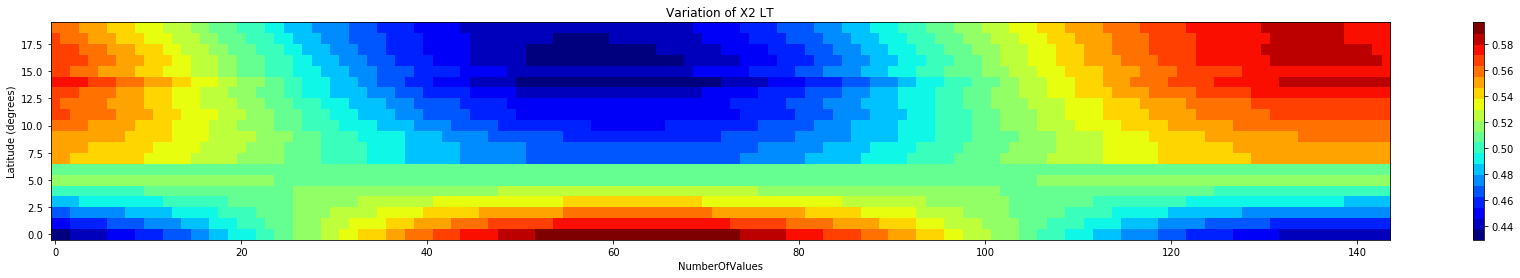

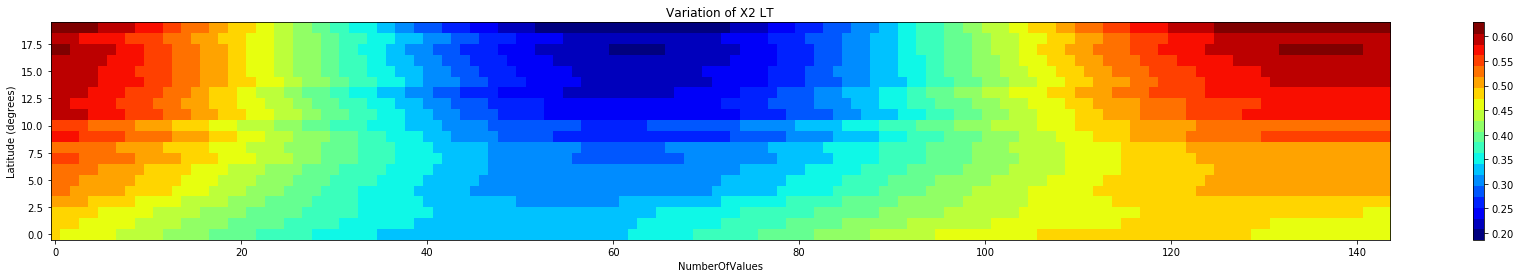

In [45]:
fig= plt.figure(figsize=(30,4))
imageIndex=5
matrixToPlot = np.load("../TrainingDataset/x_train/indicatorVariationArrayLocalTime{}.npy".format(imageIndex))
plt.imshow(matrixToPlot, origin='lower', cmap=plt.get_cmap('jet', 20) , aspect='auto')
plt.title("Variation of X2 LT")
plt.xlabel("NumberOfValues")
plt.ylabel("Latitude (degrees)")
plt.colorbar()

fig= plt.figure(figsize=(30,4))
matrixToPlot = np.load("../TrainingDataset/x_train/indicatorVariationArrayLocalTime{}.npy".format(imageIndex+1))
plt.imshow(matrixToPlot, origin='lower', cmap=plt.get_cmap('jet', 20) , aspect='auto')
plt.title("Variation of X2 LT")
plt.xlabel("NumberOfValues")
plt.ylabel("Latitude (degrees)")
plt.colorbar()